# Mean-Variance Portfolio Analysis

## Load Libraries and Data

In [1]:
# Load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
# Load data
close_prices = pd.read_csv('EUROSTOXX50DataV2.csv', index_col = 0)
Symbols = close_prices.columns

In [3]:
# Number of calendar days between first and last data points in close_prices
first_date = datetime.strptime(close_prices.index.min(), '%Y-%m-%d')
last_date = datetime.strptime(close_prices.index.max(), '%Y-%m-%d')

print("First date:", first_date.date())
print("Last date: ", last_date.date())

n_cal_days = (last_date - first_date).days
print("Calendar days between:", n_cal_days)


First date: 2022-01-04
Last date:  2025-06-27
Calendar days between: 1270


## Compute the Mean and Covariance of (Annualized) Returns

We first assume that the risk-free asset has an annualized return of 2.5\% (i.e. $r_0 = 0.025$).

**Note:** As shall be seen below, the assumed quantity satisfies the condition $r_0 < \frac{b}{a}$, the latter quantity being dependent on the data at hand.

In [4]:
# Risk-free rate (annualized)
r0 = 0.025

In [5]:
# Annualization factor
ann_factor = 1 / ((n_cal_days / 365) / len(close_prices))
ann_factor

242.56692913385825

Note that the annualization factor is close to 252, which is the usually assumed number of trading days in a calendar year.

Annualization here is useful only for ''reading'' the expected return and the standard deviation of returns. The estimates are usually very small numbers, which are cumbersome to interpret/read, so we refer to their annualized versions instead.

In [6]:
# Calculate percentage returns
daily_ret = close_prices / close_prices.shift(1) - 1
daily_ret = daily_ret.dropna()

# # Remove row with NaN
# daily_ret = daily_ret.tail(len(daily_ret) - 1)

In [7]:
# Average daily returns
mean_daily = daily_ret.mean(axis = 0)

# Compute annualized daily returns
mean_ann = ann_factor * mean_daily

# # Compare daily and annualized expected returns (in %)
# print(np.c_[mean_daily, mean_ann] * 100)

In [8]:
# Covariance matrix of daily returns
Sigma_daily = daily_ret.cov()

# Annualized covariance matrix
Sigma_ann = ann_factor * Sigma_daily 

In the subsequent analysis, we remove `^STOXX50E` from the analysis. We shall perform the mean-variance analysis on the constituent stocks only and check whether the `STOXX50E` is an efficient portfolio in this framework.

In [9]:
# Extract EURO STOXX 50 information
mean_ann_index = mean_ann.iloc[0]
var_ann_index = Sigma_ann.iloc[0,0]
std_ann_index = var_ann_index ** 0.5

print(mean_ann_index, var_ann_index, std_ann_index)

0.07387147894423153 0.033624401004428615 0.1833695749147841


In [10]:
# Overwrite mean_ann and Sigma_ann
mean_ann = mean_ann.iloc[1:len(Symbols)]
Sigma_ann = Sigma_ann.iloc[1:len(Symbols), 1:len(Symbols)]
invSigma_ann = np.linalg.inv(Sigma_ann)

# Individual (annualized) standard deviation of returns
std_ann = pd.Series(np.diag(Sigma_ann), index=Sigma_ann.columns) ** 0.5

## Mean-Variance Analysis

### The Portfolios $\phi_a$, $\omega_{a,b}$, and $\varphi_\tau$

We first calculate $a = \mathbf{1}_d^\top \Sigma^{-1} \mathbf{1}_d$ and $b = \mathbf{1}_d \Sigma^{-1} M$, as these shall appear frequently in our calculations.

In [11]:
# Important quantities
Vec1 = np.linspace(1, 1, len(mean_ann))
a = Vec1.T @ invSigma_ann @ Vec1
b = Vec1.T @ invSigma_ann @ mean_ann

print(a, b)

82.49986078137627 10.983070066617822


Next, we compute the expected return and the standard deviation of the returns of the minimum-variance portfolio $\phi_a$ and the self-financing portfolio $\omega_{a,b}$, which shall define the efficient frontier $\mathscr{F}(\sigma, m)$ in the no-risky-asset case.

In [12]:
# Properties of the minimum-variance portfolio \phi_a
phi_a = (1 / a) * invSigma_ann @ Vec1
mean_phi_a = b / a
sigma_phi_a = 1 / (a ** 0.5)

print(mean_phi_a, sigma_phi_a)

# Properties of the self-financing portfolio \omega_{a,b}
mean_omega = np.sqrt((mean_ann - (b / a) * Vec1).T @ invSigma_ann @ (mean_ann - (b / a) * Vec1))
omega = invSigma_ann @ (mean_ann - (b / a) * Vec1) / mean_omega
sigma_omega = 1

print(mean_omega, sigma_omega)

0.13312834667349122 0.11009646940648707
3.4559637425154626 1


We then compute the expected return and the standard deviation of the returns of the tangent portfolio $\varphi_\tau$.

In [13]:
# Properties of the tangent portfolio \varphi_\tau
mean_tau = r0 + (1 / (b - r0 * a)) * (mean_ann - r0 * Vec1).T @ invSigma_ann @ (mean_ann - r0 * Vec1)
sigma_tau = np.sqrt((1 / (b - r0 * a) ** 2) * (mean_ann - r0 * Vec1).T @ invSigma_ann @ (mean_ann - r0 * Vec1))

print(mean_tau, sigma_tau)

1.4720204399387804 0.40275500291296384


### Scatterplot of $(\sigma, m)$ pairs for all stocks

Text(0.40275500291296384, 1.4720204399387804, 'Tangent')

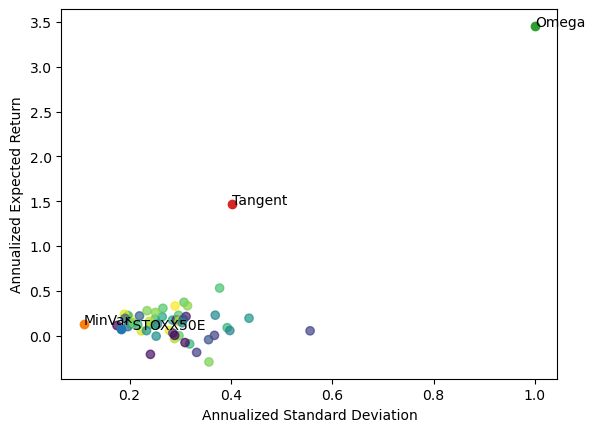

In [14]:
fig, ax = plt.subplots()

# Assign a (random) color to each stock
np.random.seed(12345)
colors = np.random.rand(len(mean_ann))

# Scatterplot of stocks on the return-risk space (\sigma, m)
plt.scatter(std_ann, mean_ann, c = colors, alpha = 0.7)
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Expected Return')

# Add the Euro Stoxx 50 to the plot and annotate
plt.scatter(std_ann_index, mean_ann_index, alpha = 1)
plt.annotate('^STOXX50E', (std_ann_index, mean_ann_index))

# Add \phi_a, \omega_{a,b}, and \varphi_\tau to the plot
plt.scatter(sigma_phi_a, mean_phi_a, alpha = 1)
plt.annotate('MinVar', (sigma_phi_a, mean_phi_a))

plt.scatter(sigma_omega, mean_omega, alpha = 1)
plt.annotate('Omega', (sigma_omega, mean_omega))

plt.scatter(sigma_tau, mean_tau, alpha = 1)
plt.annotate('Tangent', (sigma_tau, mean_tau))

### Plot $\mathscr{F}(\sigma,m)$, its asymptote, and the Capital Market Line

In [15]:
# Define the range for the plot
range_mean_high = np.max(mean_ann) + 0.5
range_mean_low = np.min(mean_ann) - 0.5

# # Define range for the plot (including tangent and \omega portfolios)
# range_mean_high = np.max(np.array([np.max(mean_ann), mean_phi_a, mean_omega, mean_tau])) + 0.5
# range_mean_low = np.min(np.array([np.min(mean_ann), mean_phi_a, mean_omega, mean_tau])) - 0.5

# Define array of expected returns for the frontier
mean_plot = np.linspace(range_mean_low, range_mean_high, 100)

Recall that the $\mathscr{F}(\sigma, m)$, its (upper) asymptote, and the capital market line are given by the following equations given the $m$-coordinates:

\begin{align*}
    \mathscr{F}(\sigma, m): & \qquad \sigma = \sqrt{\sigma_{\phi_a}^2 + \left(\frac{m - m_{\phi_a}}{m_{\omega_{a,b}}}\right)^2} \\
    \mathscr{F}(\sigma, m) \text{ asymptote}: & \qquad \sigma = \frac{1}{m_{\omega_{a,b}}}\left(m - \frac{b}{a}\right) \\
    \text{Capital Market Line}: & \qquad \sigma = \frac{\sigma_{\varphi_\tau}}{m_{\varphi_\tau} - r_0} (m - r_0)
\end{align*}

In [16]:
# Storage for points (\sigma) on the frontier, the asymptote, and the CML
sigma_F = pd.DataFrame()
sigma_asy = pd.DataFrame()
sigma_CML = pd.DataFrame()

# Compute \sigma for each of the three at each point
for i in range(len(mean_plot)):
    sigma_F[i] = [np.sqrt(sigma_phi_a ** 2 + ((mean_plot[i] - mean_phi_a) / mean_omega) ** 2)]
    sigma_asy[i] = [(mean_plot[i] - b / a) / mean_omega]
    sigma_CML[i] = [sigma_tau * (mean_plot[i] - r0) / (mean_tau - r0)]

In [17]:
# Convert data frames to arrays
sigma_F = np.array(sigma_F.iloc[0])
sigma_asy = np.array(sigma_asy.iloc[0])
sigma_CML = np.array(sigma_CML.iloc[0])

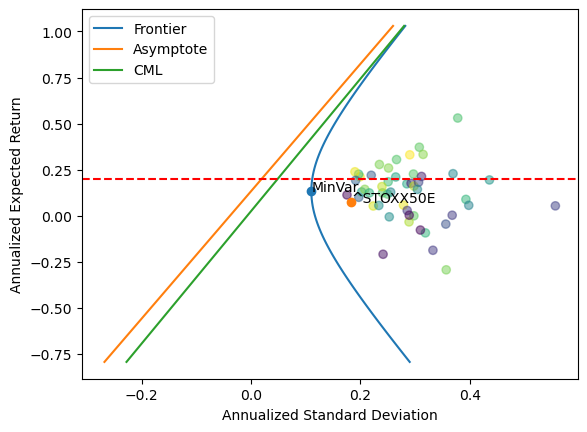

In [18]:
# Plot the frontier, the asymptote, and the CML
plt.plot(sigma_F, mean_plot, alpha = 1)
plt.plot(sigma_asy, mean_plot, alpha = 1)
plt.plot(sigma_CML, mean_plot, alpha = 1)

plt.legend(['Frontier', 'Asymptote', 'CML'], loc = 2)

plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Expected Return')

# Add the minimum variance portfolio \phi_a
plt.scatter(sigma_phi_a, mean_phi_a, alpha = 1)
plt.annotate('MinVar', (sigma_phi_a, mean_phi_a))

# # Add the portfolio \omega
# plt.scatter(sigma_omega, mean_omega, alpha = 1)
# plt.annotate('Omega', (sigma_omega, mean_omega))

# # Add the tangent portfolio
# plt.scatter(sigma_tau, mean_tau, alpha = 1)
# plt.annotate('Tangent', (sigma_tau, mean_tau))

# Add individual stocks to the plot
plt.scatter(std_ann, mean_ann, c = colors, alpha = 0.5)

# Add the Euro Stoxx 50 to the plot and annotate
plt.scatter(std_ann_index, mean_ann_index, alpha = 1)
plt.annotate('^STOXX50E', (std_ann_index, mean_ann_index))

# Horizontal line at a target (annualized) expected return (e.g. 20%)
plt.axhline(y = 0.2, color = 'r', linestyle = '--') 

### Determine the Optimal Allocation Given a Target Expected Return

#### Optimal Allocation with Risk-Free Asset

In [19]:
# Target (annualized) expected return
mean_target = 0.20

# Tangent portfolio risky allocation \phi_\tau
tangent_risky = (1 / (b - r0 * a)) * invSigma_ann @ (mean_ann - r0 * Vec1)

# Use Separation Theorem to compute the efficient portfolio with target expected return
sep_thm_coeff = (mean_target - r0) / (mean_tau - r0)

# Optimal allocation
opt_alloc = np.append(1 - sep_thm_coeff, sep_thm_coeff * tangent_risky)

# Mean and standard deviation
mean_opt = sep_thm_coeff * mean_tau + (1 - sep_thm_coeff) * r0   # should be mean_target, but just to check
sigma_opt = abs(sep_thm_coeff) * sigma_tau

In [20]:
# Check if the optimal allocation is an investment portfolio
sum(opt_alloc)

1.0000000000000004

In [21]:
# Optimal allocation as a data frame
opt_alloc_df = pd.DataFrame({'Symbol' : np.append('Risk-Free', Symbols[1:len(Symbols)]), 
                            'Allocation' : opt_alloc})

opt_alloc_df

,Symbol,Allocation
0,Risk-Free,0.879062
1,ABI.BR,-0.003067
2,AD.AS,0.012248
3,ADS.DE,-0.009302
4,ADYEN.AS,-0.009145
5,AI.PA,0.011500
6,AIR.PA,-0.039588
7,ALV.DE,0.012087
8,ASML.AS,-0.017077
9,BAS.DE,-0.000536


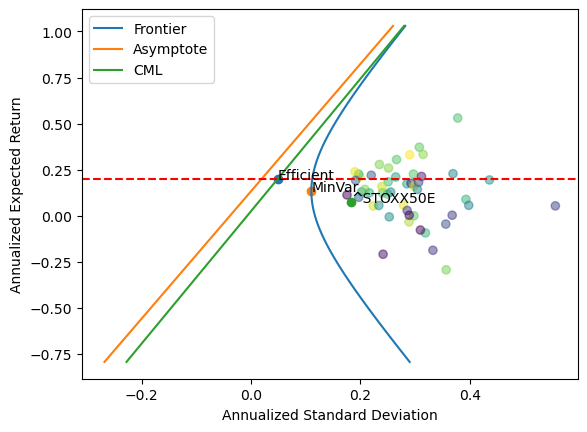

In [22]:
# Plot the frontier, the asymptote, and the CML
plt.plot(sigma_F, mean_plot, alpha = 1)
plt.plot(sigma_asy, mean_plot, alpha = 1)
plt.plot(sigma_CML, mean_plot, alpha = 1)

plt.legend(['Frontier', 'Asymptote', 'CML'], loc = 2)

plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Expected Return')

# Add the efficient portfolio calculated in the previous step
plt.scatter(sigma_opt, mean_opt, alpha = 1)
plt.annotate('Efficient', (sigma_opt, mean_opt))

# Add the minimum variance portfolio \phi_a
plt.scatter(sigma_phi_a, mean_phi_a, alpha = 1)
plt.annotate('MinVar', (sigma_phi_a, mean_phi_a))

# Add individual stocks to the plot
plt.scatter(std_ann, mean_ann, c = colors, alpha = 0.5)

# Add the Euro Stoxx 50 to the plot and annotate
plt.scatter(std_ann_index, mean_ann_index, alpha = 1)
plt.annotate('^STOXX50E', (std_ann_index, mean_ann_index))

# Horizontal line at a target (annualized) expected return (e.g. 20%)
plt.axhline(y = 0.2, color = 'r', linestyle = '--') 

As expected, this efficient portfolio is located on the capital market line, as it contains an allocation to the risk-free asset.

#### Optimal Allocation without a Risk-Free Asset

To calculate the optimal allocation without a risk-free asset, recall that portfolios in $\mathscr{F}$ have the representation 

$$\phi = \phi_a + \lambda \omega_{a,b}$$

for some $\lambda \in \mathbb{R}$. To determine the appropriate value of $\lambda$ to achieve a target expected return $m_\phi = \bar{m}$, we note that, in Proposition 3.9, we have $m_\phi = m_{\phi_a} + \lambda m_{\omega_{a,b}}$. This implies that the $\lambda$ associated to the target expected return $\bar{m}$ is $\lambda = (\bar{m} - m_{\phi_a}) / m_{\omega_{a,b}}$. This implies that the optimal investment strategy to achieve the target expected return $\bar{m}$ is

$$\phi^* = \phi_a + \frac{\bar{m} - m_{\phi_a}}{m_{\omega_{a,b}}} \omega_{a,b}.$$

In [23]:
# Optimal allocation with no risk-free asset
opt_alloc_nrf = phi_a + ((mean_target - mean_phi_a) / mean_omega) * omega

# Mean and standard deviation of the optimal allocation
mean_opt_nrf = mean_target
sigma_opt_nrf = np.sqrt(sigma_phi_a ** 2 + ((mean_opt_nrf - mean_phi_a) / mean_omega) ** 2)

In [24]:
# Check if the optimal allocation is an investment portfolio
sum(opt_alloc_nrf)

0.9999999999999992

In [25]:
# Optimal allocation (no risk-free) as a data frame
opt_alloc_nrf_df = pd.DataFrame({'Symbol' : Symbols[1:len(Symbols)], 
                            'Allocation' : opt_alloc_nrf})

opt_alloc_nrf_df

,Symbol,Allocation
0,ABI.BR,-0.029618
1,AD.AS,0.137536
2,ADS.DE,-0.022863
3,ADYEN.AS,-0.039372
4,AI.PA,-0.006867
5,AIR.PA,-0.063498
6,ALV.DE,0.058164
7,ASML.AS,-0.004520
8,BAS.DE,0.024073
9,BAYN.DE,-0.021643


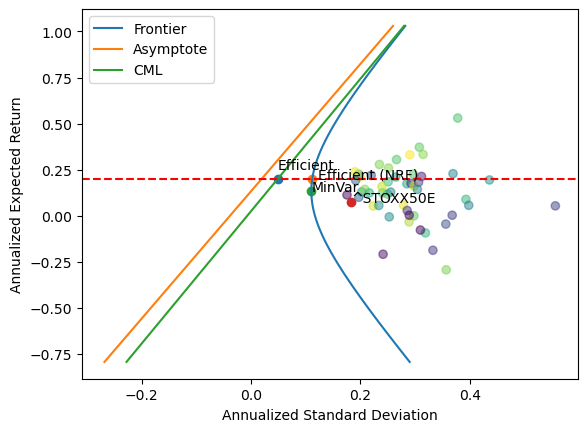

In [26]:
# Plot the frontier, the asymptote, and the CML
plt.plot(sigma_F, mean_plot, alpha = 1)
plt.plot(sigma_asy, mean_plot, alpha = 1)
plt.plot(sigma_CML, mean_plot, alpha = 1)

plt.legend(['Frontier', 'Asymptote', 'CML'], loc = 2)

plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Expected Return')

# Add the efficient portfolio with risk-free asset calculated in the previous step
plt.scatter(sigma_opt, mean_opt, alpha = 1)
plt.annotate('Efficient', (sigma_opt, mean_opt + 0.05))

# Add the efficient portfolio with no risk-free asset calculated in the previous step
plt.scatter(sigma_opt_nrf, mean_opt_nrf, alpha = 1)
plt.annotate('Efficient (NRF)', (sigma_opt_nrf + 0.01, mean_opt_nrf))

# Add the minimum variance portfolio \phi_a
plt.scatter(sigma_phi_a, mean_phi_a, alpha = 1)
plt.annotate('MinVar', (sigma_phi_a, mean_phi_a))

# Add individual stocks to the plot
plt.scatter(std_ann, mean_ann, c = colors, alpha = 0.5)

# Add the Euro Stoxx 50 to the plot and annotate
plt.scatter(std_ann_index, mean_ann_index, alpha = 1)
plt.annotate('^STOXX50E', (std_ann_index, mean_ann_index))

# Horizontal line at a target (annualized) expected return (e.g. 20%)
plt.axhline(y = 0.2, color = 'r', linestyle = '--') 

## Mean-Variance Analysis with Constraints

As seen in ``opt_alloc_nrf_df``, the efficient portfolio with no risk-free allocation requires a mix of long and short positions in the risky asset, with an allocation sometimes exceeding 50\%. The next implementation provides a numerical solution of the mean-variance optimization problem in which we impose additional restrictions, such as short-selling constraints (no negative allocations) or upper bounds on long positions.

Specifically, we consider the mean-variance optimization problem with no risk-free asset where short-selling is not allowed ($\phi \geq 0 \cdot \mathbf{1}_d$ componentwise) and any position must be worth at most 10\% of the initial wealth ($\phi \leq 10\% \cdot \mathbf{1}_d$ componentwise). The optimization problem can thus be written as

\begin{align*}
\min_{\phi \in \mathbb{R}^d} & \quad \phi^\top \Sigma \phi \\
\text{subject to} & \quad M^\top \phi = \bar{m} \\
& \quad \mathbf{1}_d^\top \phi = 1 \\
& \quad -\phi \leq 0 \cdot \mathbf{1}_d \\
& \quad \phi \leq 10\% \cdot \mathbf{1}_d.
\end{align*}

As there is often no closed-form solution for the constrained optimization problem, we will rely on **quadratic programming (QP) problem solvers** in Python. The general form of QP problems that can be solved using this library is

\begin{align*}
\min_{x \in \mathbb{R}^d} & \quad \frac{1}{2} x^\top P x + q^\top x \\
\text{subject to} & \quad Gx \leq h \\
& \quad Ax = b,
\end{align*}

where $P, G, A$ are matrices and $q, h, b$ are vectors. Comparing the general form to our mean-variance optimization problem, we make the following identifications:

$$P = 2\Sigma \in \mathbb{R}^{d\times d}, \quad q = 0 \cdot \mathbf{1}_d \in \mathbb{R}^d, \quad G = \left[\begin{array}{c} - \mathbf{I}_d \\ \mathbf{I}_d\end{array}\right] \in \mathbb{R}^{2d \times d} \\ h = \left[\begin{array}{c} 0 \cdot \mathbf{1}_d \\ 10\% \cdot \mathbf{1}_d\end{array}\right] \in \mathbb{R}^{2d}, \quad A = \left[\begin{array}{ccc} m_1 & \cdots & m_d \\ 1 & \cdots & 1 \end{array}\right] \in \mathbb{R}^{2\times d}, \quad b = \left[\begin{array}{c} \bar{m} \\ 1 \end{array}\right] \in \mathbb{R}^2.$$

Here, $\mathbf{I}_d$ is the $d\times d$ identity matrix.

In [27]:
# Install qpsolvers
%pip install qpsolvers
%pip install daqp

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [28]:
# Load qpsolvers library
import daqp
from qpsolvers import solve_qp

In [29]:
# Define d and set upper investment constraint
d = len(mean_ann)
upper_inv_cons = 0.1
lower_inv_cons = 0

# Define matrices for qpsolver
P = np.array(2 * Sigma_ann)
q = np.zeros(d)
G1 = np.diag([-1] * d)
G2 = np.diag([1] * d)
G = np.vstack([G1, G2])
h = np.array([lower_inv_cons] * d + [upper_inv_cons] * d)
A = np.array([mean_ann, [1] * d])
b_cons = np.array([mean_target, 1])    # To avoid conflict with the quantity b

# Solve for optimal allocation
opt_alloc_cons = np.round(solve_qp(P, q, G, h, A, b_cons, solver = 'daqp'), decimals = 4)

# Mean and standard deviation of optimal allocation
mean_opt_cons = opt_alloc_cons @ mean_ann
var_opt_cons = opt_alloc_cons.T @ Sigma_ann @ opt_alloc_cons
sigma_opt_cons = np.sqrt(var_opt_cons)

print(mean_opt_cons, sigma_opt_cons)

0.19999852625917566 0.12925245068778984


In [30]:
# Check if the optimal allocation is an investment portfolio
sum(opt_alloc_cons)

0.9999

In [31]:
# Optimal allocation (constrained) as a data frame
opt_alloc_cons_df = pd.DataFrame({'Symbol' : Symbols[0:(len(Symbols)-1)], 
                            'Allocation' : opt_alloc_cons})

opt_alloc_cons_df

,Symbol,Allocation
0,^STOXX50E,-0.0000
1,ABI.BR,0.1000
2,AD.AS,-0.0000
3,ADS.DE,-0.0000
4,ADYEN.AS,-0.0000
5,AI.PA,-0.0000
6,AIR.PA,0.0000
7,ALV.DE,-0.0000
8,ASML.AS,0.0000
9,BAS.DE,0.0000


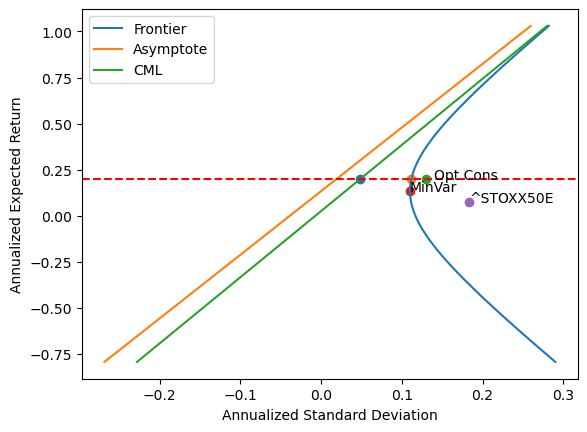

In [32]:
# Plot the frontier, the asymptote, and the CML
plt.plot(sigma_F, mean_plot, alpha = 1)
plt.plot(sigma_asy, mean_plot, alpha = 1)
plt.plot(sigma_CML, mean_plot, alpha = 1)

plt.legend(['Frontier', 'Asymptote', 'CML'], loc = 2)

plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Expected Return')

# Add the efficient portfolio with risk-free asset calculated in the previous step
plt.scatter(sigma_opt, mean_opt, alpha = 1)
# plt.annotate('Efficient', (sigma_opt, mean_opt + 0.05))

# Add the efficient portfolio with no risk-free asset calculated in the previous step
plt.scatter(sigma_opt_nrf, mean_opt_nrf, alpha = 1)
# plt.annotate('Efficient (NRF)', (sigma_opt_nrf + 0.01, mean_opt_nrf))

# Add the optimal (constrained) portfolio
plt.scatter(sigma_opt_cons, mean_opt_cons, alpha = 1)
plt.annotate('Opt Cons', (sigma_opt_cons + 0.01, mean_opt_cons))

# Add the minimum variance portfolio \phi_a
plt.scatter(sigma_phi_a, mean_phi_a, alpha = 1)
plt.annotate('MinVar', (sigma_phi_a, mean_phi_a))

# Add individual stocks to the plot
# plt.scatter(std_ann, mean_ann, c = colors, alpha = 0.5)

# Add the Euro Stoxx 50 to the plot and annotate
plt.scatter(std_ann_index, mean_ann_index, alpha = 1)
plt.annotate('^STOXX50E', (std_ann_index, mean_ann_index))

# Horizontal line at a target (annualized) expected return (e.g. 20%)
plt.axhline(y = 0.2, color = 'r', linestyle = '--') 

## Correlation Adjustment

We adjust the diagonal entries of the covariance matrix $\Sigma$ by multiplying it by $(1+\delta^2)$ and investigate whether it reduces the number of extremely large long and short positions (in the unconstrained case) or the number of allocations equal to the boundary values (in the constrained case).

We shall use $\delta = 0.3$ in the following illustrations.

### Unconstrained Case

In [33]:
# Define adjustment param
adj_param = 0.3

# Adjust the covariance matrix diagonal entries
Sigma_ann_adj = np.array(Sigma_ann)
np.fill_diagonal(Sigma_ann_adj, (1 + adj_param ** 2) * np.diag(Sigma_ann))
Sigma_ann_adj = pd.DataFrame(Sigma_ann_adj, index = Sigma_ann.columns)
Sigma_ann_adj.columns = Sigma_ann.columns

# Compute inverse of the adjusted covariance matrix
invSigma_ann_adj = np.linalg.inv(Sigma_ann_adj)

In [34]:
# Solve the optimization problem (no risk-free asset) with the adjusted covariance matrix
a_adj = Vec1.T @ invSigma_ann_adj @ Vec1
b_adj = Vec1.T @ invSigma_ann_adj @ mean_ann
phi_a_adj = (1 / a_adj) * invSigma_ann_adj @ Vec1
mean_omega_adj = np.sqrt((mean_ann - (b_adj / a_adj) * Vec1).T @ invSigma_ann_adj @ (mean_ann - (b_adj / a_adj) * Vec1))
omega_adj = invSigma_ann_adj @ (mean_ann - (b_adj / a_adj) * Vec1) / mean_omega_adj
opt_alloc_nrf_adj = phi_a_adj + ((mean_target - (b_adj / a_adj)) / mean_omega) * omega_adj

# Mean and standard deviation of the optimal allocation
mean_opt_nrf_adj = mean_target
sigma_opt_nrf_adj = np.sqrt(opt_alloc_nrf_adj.T @ Sigma_ann_adj @ opt_alloc_nrf_adj)

# Check if the optimal allocation is an investment portfolio
sum(opt_alloc_nrf_adj)

# Optimal allocation (no risk-free) as a data frame
opt_alloc_nrf_adj_df = pd.DataFrame({'Symbol' : Symbols[0:(len(Symbols)-1)], 
                                    'Allocation (Orig)' : opt_alloc_nrf,
                                    'Allocation (Adj)' : opt_alloc_nrf_adj})

opt_alloc_nrf_adj_df

,Symbol,Allocation (Orig),Allocation (Adj)
0,^STOXX50E,-0.029618,-0.016887
1,ABI.BR,0.137536,0.138107
2,AD.AS,-0.022863,-0.019958
3,ADS.DE,-0.039372,-0.034048
4,ADYEN.AS,-0.006867,0.003794
5,AI.PA,-0.063498,-0.052086
6,AIR.PA,0.058164,0.048583
7,ALV.DE,-0.004520,-0.002233
8,ASML.AS,0.024073,0.016167
9,BAS.DE,-0.021643,-0.015570


### Constrained Case

In [35]:
# Define d and set upper investment constraint
d = len(mean_ann)
upper_inv_cons = 0.1
lower_inv_cons = 0

# Define matrices for qpsolver
P_adj = np.array(2 * Sigma_ann_adj)
q = np.zeros(d)
G1 = np.diag([-1] * d)
G2 = np.diag([1] * d)
G = np.vstack([G1, G2])
h = np.array([lower_inv_cons] * d + [upper_inv_cons] * d)
A = np.array([mean_ann, [1] * d])
b_cons = np.array([mean_target, 1])    # To avoid conflict with the quantity b

# Solve for optimal allocation
opt_alloc_cons_adj = np.round(solve_qp(P_adj, q, G, h, A, b_cons, solver = 'daqp'), decimals = 4)

# Mean and standard deviation of optimal allocation
mean_opt_cons_adj = opt_alloc_cons_adj @ mean_ann
var_opt_cons_adj = opt_alloc_cons_adj.T @ Sigma_ann_adj @ opt_alloc_cons_adj
sigma_opt_cons_adj = np.sqrt(var_opt_cons_adj)

# Optimal allocation (constrained) as a data frame
opt_alloc_cons_adj_df = pd.DataFrame({'Symbol' : Symbols[0:(len(Symbols)-1)], 
                                      'Allocation (Orig)' : opt_alloc_cons,
                                      'Allocation (Adj)' : opt_alloc_cons_adj})

opt_alloc_cons_adj_df

,Symbol,Allocation (Orig),Allocation (Adj)
0,^STOXX50E,-0.0000,0.0000
1,ABI.BR,0.1000,0.1000
2,AD.AS,-0.0000,0.0000
3,ADS.DE,-0.0000,-0.0000
4,ADYEN.AS,-0.0000,0.0000
5,AI.PA,-0.0000,0.0000
6,AIR.PA,0.0000,0.0064
7,ALV.DE,-0.0000,0.0000
8,ASML.AS,0.0000,-0.0000
9,BAS.DE,0.0000,0.0000


The correlation adjusted yields a very small difference in the constrained case, as many positions are still equal to the upper or lower investment constraints. However, the effect is more obvious in the unconstrained case. We posit that the investment constraint $\phi_i \in [0,0.10]$ may be too stringent and should be loosened.

We show below the efficient frontier along with the optimal allocations obtained using the adjusted covariance matrix.

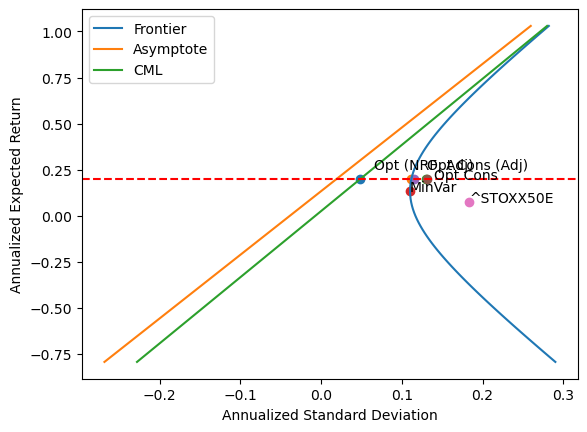

In [36]:
# Plot the frontier, the asymptote, and the CML
plt.plot(sigma_F, mean_plot, alpha = 1)
plt.plot(sigma_asy, mean_plot, alpha = 1)
plt.plot(sigma_CML, mean_plot, alpha = 1)

plt.legend(['Frontier', 'Asymptote', 'CML'], loc = 2)

plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Expected Return')

# Add the efficient portfolio with risk-free asset calculated in the previous step
plt.scatter(sigma_opt, mean_opt, alpha = 1)
# plt.annotate('Efficient', (sigma_opt, mean_opt + 0.05))

# Add the efficient portfolio with no risk-free asset calculated in the previous step
plt.scatter(sigma_opt_nrf, mean_opt_nrf, alpha = 1)
# plt.annotate('Efficient (NRF)', (sigma_opt_nrf + 0.01, mean_opt_nrf))

# Add the optimal (constrained) portfolio
plt.scatter(sigma_opt_cons, mean_opt_cons, alpha = 1)
plt.annotate('Opt Cons', (sigma_opt_cons + 0.01, mean_opt_cons))

# Add the minimum variance portfolio \phi_a
plt.scatter(sigma_phi_a, mean_phi_a, alpha = 1)
plt.annotate('MinVar', (sigma_phi_a, mean_phi_a))

# Add the optimal (unconstrained adjusted) portfolio
plt.scatter(sigma_opt_nrf_adj, mean_opt_nrf_adj, alpha = 1)
plt.annotate('Opt (NRF, Adj)', (sigma_opt_nrf_adj - 0.05, mean_opt_nrf_adj + 0.05))

# Add the optimal (constrained adjusted) portfolio
plt.scatter(sigma_opt_cons_adj, mean_opt_cons_adj, alpha = 1)
plt.annotate('Opt Cons (Adj)', (sigma_opt_cons_adj, mean_opt_cons_adj + 0.05))

# Add individual stocks to the plot
# plt.scatter(std_ann, mean_ann, c = colors, alpha = 0.5)

# Add the Euro Stoxx 50 to the plot and annotate
plt.scatter(std_ann_index, mean_ann_index, alpha = 1)
plt.annotate('^STOXX50E', (std_ann_index, mean_ann_index))

# Horizontal line at a target (annualized) expected return (e.g. 20%)
plt.axhline(y = 0.2, color = 'r', linestyle = '--') 

## Estimating the Beta of a Stock

In this section, we illustrate the estimation of the beta of a stock with respect to the tangent portfolio. The approach here is similar to a historical simulation approach where we use historical risky asset returns to generate (historically) simulated returns for the tangent portfolio under the assumption that its composition is fixed to ``tangent_risky``. Likewise, the historical returns of each stock shall be treated as simulated values of the unknown return.

In [37]:
# Define the time series of daily returns of the risky assets
daily_ret_noindex = daily_ret.iloc[:,0:(len(daily_ret.columns)-1)]
daily_ret_noindex = daily_ret_noindex.dropna()   # Remove NaNs (needed for regression)

# Annualize the daily returns
daily_ret_noindex = ann_factor * daily_ret_noindex

*Note:* Since the number of observations is reduced after removing the NaNs, we may choose to re-compute the annualization factor. But this is not recommended since doing so may yield results that are slightly inconsistent with the returns analyzed above.

In [38]:
# Calculate (historical) simulations of the (annualized) returns tangent portfolio assuming fixed composition
tangent_ret = daily_ret_noindex @ tangent_risky
np.average(tangent_ret)   # Check if similar to mean_tau computed above

# Excess returns of the tangent portfolio (relative to the risk-free rate)
exc_ret_tangent = (tangent_ret - r0).array    # Convert to array for scikit-learn regression

### Example: Estimating the Beta of BNP Paribas stock (BNP.PA)

We first illustrate the regression method to estimate the beta of the BNP Paribas stock (``BNP.PA``) with respect to the tangent portfolio.

In [39]:
# Excess returns of the stock
exc_ret_stock = (daily_ret_noindex['BNP.PA'] - r0).array   # Convert to array for scikit-learn regression

# Display as data frame
exc_ret_df = pd.DataFrame({'Stock': exc_ret_stock, 'Tangent': exc_ret_tangent})
exc_ret_df

,Stock,Tangent
0,0.281798,-6.069864
1,4.456376,1.674838
2,-1.905383,-4.129875
3,1.339424,13.152964
4,3.630840,13.604393
...,...,...
838,-5.094701,1.730833
839,7.609119,-8.172747
840,-0.572036,-12.510492
841,0.168496,3.775126


In [40]:
# # Install scikit-learn
# !pip install scikit-learn

In [41]:
# Load scikit-learn library for regression
from sklearn.linear_model import LinearRegression

In [42]:
# Fit regression model with no intercept
reg = LinearRegression(fit_intercept = False).fit(exc_ret_tangent.reshape(-1, 1), exc_ret_stock)
beta = reg.coef_[0]
rsq = reg.score(exc_ret_tangent.reshape(-1, 1), exc_ret_stock)

print(beta, rsq)

0.10983762969205342 0.026501537405491438


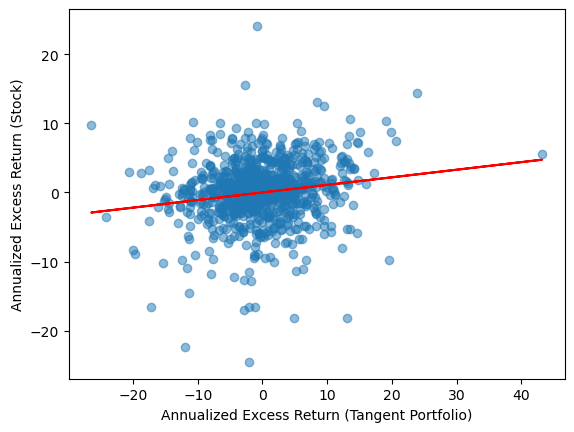

In [43]:
# Scatter plot of (historical) returns and the beta
plt.scatter(exc_ret_tangent, exc_ret_stock, alpha = 0.5)

plt.xlabel('Annualized Excess Return (Tangent Portfolio)')
plt.ylabel('Annualized Excess Return (Stock)')

# Plot the regression line with slope equal to beta
plt.plot(exc_ret_tangent, beta * exc_ret_tangent, color = 'red')

### Estimating the Beta for All Stocks

In [44]:
# Storage for estimated betas
stock_betas = pd.DataFrame()
stock_rsq = pd.DataFrame()

# Iterate over each stock
for i in daily_ret_noindex.columns:
    exc_ret_stock = (daily_ret_noindex[i] - r0).array
    reg = LinearRegression(fit_intercept = False).fit(exc_ret_tangent.reshape(-1, 1), exc_ret_stock)
    beta = reg.coef_[0]
    rsq = reg.score(exc_ret_tangent.reshape(-1, 1), exc_ret_stock)
    stock_betas[i] = [beta]
    stock_rsq[i] = [rsq]

Text(0, 0.5, 'Annualized Expected Return')

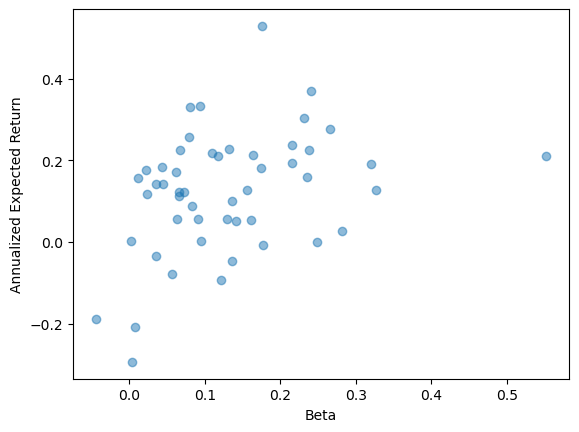

In [45]:
# Display stocks on the beta-expected return plane
plt.scatter(stock_betas, mean_ann, alpha = 0.5)

plt.xlabel('Beta')
plt.ylabel('Annualized Expected Return')

## Appendix: Functions for Mean-Variance Optimal Portfolios

In [46]:
# Mean-variance optimal portfolios (no risk-free asset)

def mv_optim_nrf(target_mean, mean_return_vector, return_covariance_matrix):
    
    """
    Determines the composition of the mean-variance optimal portfolio for the given target mean.
    Computes the composition of the minimum-variance portfolio and the self-financing portfolio \omega_{a,b}.
    
    usage:
        mv_optimal_portfolio, minvar_portfolio, omega_portfolio
            = mv_optim_nrf(target_mean, mean_return_vector, return_covariance_matrix)
    
    inputs:
        target_mean               : target expected (annualized) return of the mean-variance optimal portfolio
        mean_return_vector        : mean of returns of the risky assets (annualized)
        return_covariance_matrix  : covariance of the returns of the risky assets (annualized)
    
    outputs:
        mv_optimal_portfolio      : composition of the mean-variance optimal (investment) portfolio satisfying the target mean
        minvar_portfolio          : composition of the minimum-variance (investment) portfolio (with risky allocation only)
        omega_portfolio           : composition of the self-financing portfolio \omega_{a,b}
    """
    
    # Introduce notation
    mean_ann = mean_return_vector
    Sigma_ann = return_covariance_matrix
    
    # Calculate commonly occuring quantities
    invSigma_ann = np.linalg.inv(Sigma_ann)
    Vec1 = np.linspace(1, 1, len(mean_ann))
    a = Vec1.T @ invSigma_ann @ Vec1
    b = Vec1.T @ invSigma_ann @ mean_ann
    
    # Calculate composition of minimum-variance portfolio
    minvar_portfolio = (1 / a) * invSigma_ann @ Vec1
    
    # Calculate composition of omega_{a,b}
    mean_omega = np.sqrt((mean_ann - (b / a) * Vec1).T @ invSigma_ann @ (mean_ann - (b / a) * Vec1))
    omega_portfolio = invSigma_ann @ (mean_ann - (b / a) * Vec1) / mean_omega
    
    # Calculate composition of the mv-optimal portfolio given the target mean
    mv_optimal_portfolio = minvar_portfolio + ((target_mean - (b / a)) / mean_omega) * omega_portfolio
    
    return(mv_optimal_portfolio, minvar_portfolio, omega_portfolio)

    ## END

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/var/folders/2r/59cqhtzx06xgjs81x24_5__00000gn/T/ipykernel_23038/2471046883.py:5: SyntaxWarning: invalid escape sequence '\o'
  """


In [47]:
# Test the function
phi_mv, phi_minvar, omega = mv_optim_nrf(target_mean = 0.20, mean_return_vector = mean_ann, 
                                         return_covariance_matrix = Sigma_ann)

print(phi_mv @ mean_ann, phi_minvar @ mean_ann, omega @ mean_ann)

0.19999999999999982 0.133128346673491 3.455963742515462


In [48]:
# Mean-variance optimal portfolios (with risk-free asset)

def mv_optim_wrf(target_mean, risk_free_rate, mean_return_vector, return_covariance_matrix):
    
    """
    Determines the composition of the mean-variance optimal portfolio (with risk-free allocation) 
    for the given target mean. Computes the composition of the tangent portfolio.
    
    usage:
        mv_optimal_portfolio_wrf, tangent_portfolio
            = mv_optim_wrf(target_mean, risk_free_rate, mean_return_vector, return_covariance_matrix)
    
    inputs:
        target_mean               : target expected (annualized) return of the mean-variance optimal portfolio
        risk_free_rate            : rate of return (annualized) of the risk-free asset
        mean_return_vector        : mean of returns of the risky assets (annualized)
        return_covariance_matrix  : covariance of the returns of the risky assets (annualized)
    
    outputs:
        mv_optimal_portfolio_wrf  : composition of the mean-variance optimal (investment) portfolio 
                                    with risk-free allocation satisfying the target mean
        tangent_portfolio         : composition (risky asset allocation) of the tangent portfolio
    """
    
    # Introduce notation
    mean_ann = mean_return_vector
    Sigma_ann = return_covariance_matrix
    r0 = risk_free_rate
    
    # Calculate commonly occuring quantities
    invSigma_ann = np.linalg.inv(Sigma_ann)
    Vec1 = np.linspace(1, 1, len(mean_ann))
    a = Vec1.T @ invSigma_ann @ Vec1
    b = Vec1.T @ invSigma_ann @ mean_ann
    
    # Calculate composition (risky asset allocation) of tangent portfolio
    tangent_portfolio = (1 / (b - r0 * a)) * invSigma_ann @ (mean_ann - r0 * Vec1)

    # Use Separation Theorem to compute the efficient portfolio with target expected return
    mean_tau = tangent_portfolio @ mean_ann
    sep_thm_coeff = (target_mean - r0) / (mean_tau - r0)

    # Optimal allocation
    mv_optimal_portfolio_wrf = np.append(1 - sep_thm_coeff, sep_thm_coeff * tangent_portfolio)
    
    return(mv_optimal_portfolio_wrf, tangent_portfolio)

    ## END

In [49]:
# Test the function
mv_optimal_portfolio_wrf, tangent_portfolio = mv_optim_wrf(target_mean = 0.20, risk_free_rate = r0, 
                                                           mean_return_vector = mean_ann, 
                                                           return_covariance_matrix = Sigma_ann)

tangent_portfolio @ mean_ann

1.4720204399387806

In [50]:
mean_ann

ABI.BR       0.052432
AD.AS        0.099646
ADS.DE       0.002372
ADYEN.AS     0.053253
AI.PA        0.128737
AIR.PA       0.172726
ALV.DE       0.211099
ASML.AS      0.088343
BAS.DE      -0.000809
BAYN.DE     -0.093547
BBVA.MC      0.371612
BMW.DE       0.057337
BN.PA        0.112604
BNP.PA       0.175723
CS.PA        0.219215
DB1.DE       0.225120
DG.PA        0.142905
DHL.DE      -0.033881
DTE.DE       0.238170
EL.PA        0.117303
ENEL.MI      0.123545
ENI.MI       0.123724
FLTR.L       0.227883
IBE.MC       0.191746
IFX.DE       0.056213
INGA.AS      0.225959
ISP.MI       0.330330
ITX.MC       0.184047
KER.PA      -0.294047
MBG.DE       0.028095
MC.PA       -0.078092
MUV2.DE      0.277837
NDA-FI.HE    0.157747
NOKIA.HE     0.002396
OR.PA       -0.006464
PRX.AS       0.193907
RACE.MI      0.209922
RI.PA       -0.209514
RMS.PA       0.160559
SAF.PA       0.304522
SAN.MC       0.332583
SAN.PA       0.055267
SAP.DE       0.258612
SGO.PA       0.213013
SIE.DE       0.181518
STLAM.MI  